# Prueba técnica W & J parte 6
- por David Ricardo Vivas Ordóñez

For this last challenge we will examine the dates column of our dataset

In [ ]:
### descarga del dataset
!gdown --id 18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp

Downloading...
From: https://drive.google.com/uc?id=18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp
To: /content/News_Category_Dataset_v2.json
83.9MB [00:00, 267MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud

from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

nltk.download('punkt')
nltk.download('stopwords')

sns.set_theme()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v2.json', lines=True)
n_categories = df.category.nunique()
df['category'] = pd.Categorical(df['category'])
df['category_label'] = df['category'].cat.codes
categories = df['category'].cat.categories

We will focus on the information regarding years, from now on

In [ ]:
df.sort_values(by='date')
df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['year'] = pd.Categorical(df['year'])
df['year_label'] = df['year'].cat.codes
years = df['year'].cat.categories
df = df.sort_index(axis=1)
df.head()

,authors,category,category_label,date,headline,link,short_description,year,year_label
0,Melissa Jeltsen,CRIME,6,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018,6
1,Andy McDonald,ENTERTAINMENT,10,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018,6
2,Ron Dicker,ENTERTAINMENT,10,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018,6
3,Ron Dicker,ENTERTAINMENT,10,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018,6
4,Ron Dicker,ENTERTAINMENT,10,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018,6


Lets visualize the ammount of articles per year

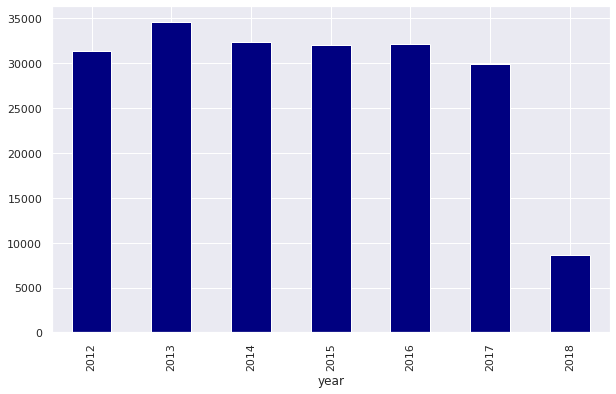

In [ ]:
ax = df.groupby("year").count()["headline"].plot(kind="bar", color = 'navy',
                                                 figsize=(10, 6),)
plt.show()

The distribution is almost uniform for 2012-2017. The ammount of news articles published in 2018 is significantly lower as the dataset only encomprises until may of such year. 

Now we extract the concatenation of articles per year

In [ ]:
year_strings = []
sample_size = 5000

for i in range(0, len(years)):
    year_strings.append(df[df['year_label'] == i]['short_description'].sample(sample_size).sum())
    # print(i)

df2 = pd.DataFrame({'year': years, 'text': year_strings})
df2.head()

,year,text
0,2012,I'm not particularly proud of three failed mar...
1,2013,We need a plan for managing mental health and ...
2,2014,Alaskans go to the polls today to settle the c...
3,2015,Too many businesses are concerned with making ...
4,2016,"""You have to appreciate who you are in order t..."


We can now visualize the most relevant words per year using TF-IDF as in challenge #2

In [ ]:
processed_strings = df2['text'].map(preprocess_string)
dictionary = Dictionary(processed_strings)
dictionary.filter_extremes(no_below=0, no_above=0.8)
training_examples = [dictionary.doc2bow(item) for item in processed_strings]
model = TfidfModel(corpus = training_examples, id2word = dictionary.id2token, dictionary = dictionary)

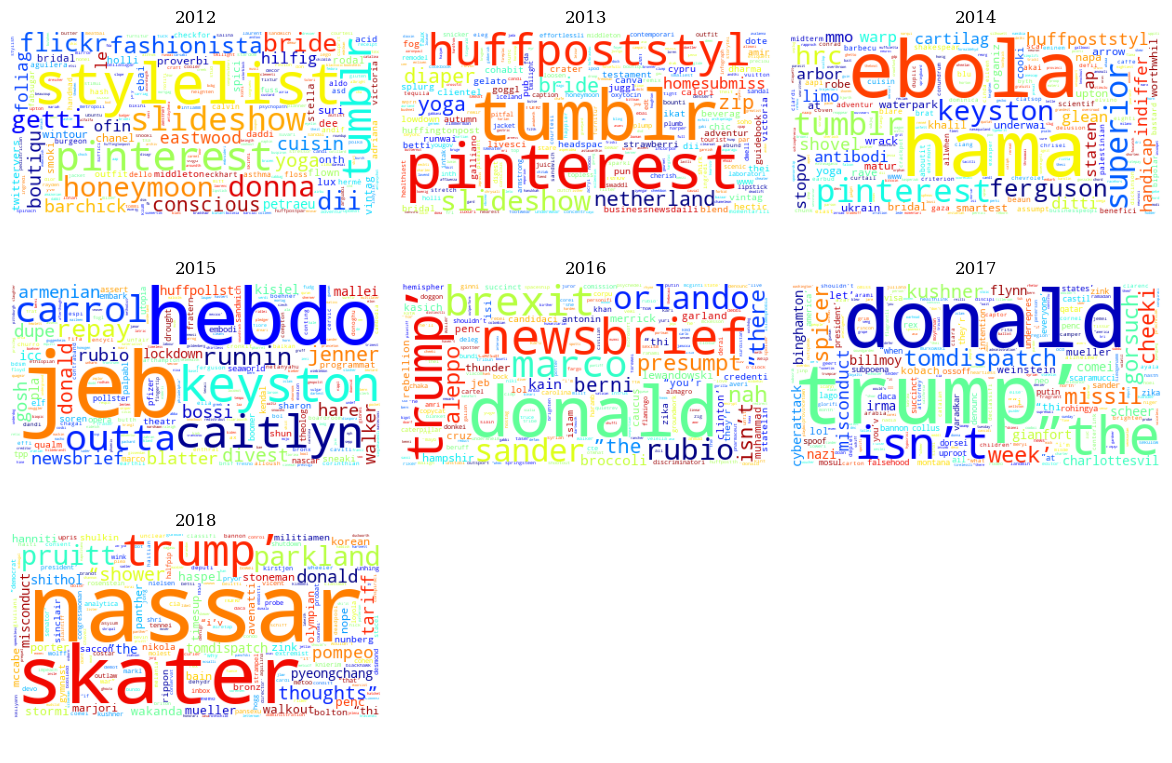

In [ ]:
plt.rcParams["font.family"] = "serif"
plot_scale = 0.66

n_cols = 3
b_color = 'white'
f_color = 'black'

fig, axs = plt.subplots(ncols=n_cols, 
                        nrows=int(np.ceil(len(years)/n_cols)), 
                        figsize=(18*plot_scale,12*plot_scale), 
                        dpi = 100, 
                        facecolor = b_color)
axs = axs.flatten() # for easer iteration

for i in range(len(years)):

    vals = model[training_examples[i]]
    vals = [(dictionary[item[0]], item[1]) for item in vals]

    axs[i].set_title(years[i], color = f_color)
    mat = WordCloud(background_color=b_color, 
                    max_words=2000, 
                    random_state=5,
                    colormap = 'jet').generate_from_frequencies(dict(vals))
    axs[i].imshow(mat)
    axs[i].axis('off')

axs[-1].axis('off')
axs[-2].axis('off')

plt.tight_layout()

plt.savefig('keywords.pdf')

plt.show()